In [47]:
def plot_present_future_changes(axes, row, input_df_changes, variable, variable_to_plot_present, variable_to_plot_future, 
                                variable_to_plot_diff, cmap, cmap_diff, low_lim, high_lim, diff_high_lim, diff_low_lim):
    # Present Climate 
    present_data = input_df_changes[['gauge_num', variable_to_plot_present]].copy()
    present_data['Climate'] = 'present'  # Add a Climate column for clarity
    # Future Climate
    future_data = input_df_changes[['gauge_num', variable_to_plot_future]].copy()
    future_data['Climate'] = 'future'  # Add a Climate column for clarity
    # Change 
    change_data = input_df_changes[['gauge_num', variable_to_plot_diff]].copy()
    change_data['Climate'] = 'change'  # Add a Climate column for clarity

    global_min = min(present_data[variable_to_plot_present].min(),
                     future_data[variable_to_plot_future].min())
    global_max = max(present_data[variable_to_plot_present].max(),
                     future_data[variable_to_plot_future].max())
    
    ### Plot
    if len(axes.shape) == 1:
        # Case with just one row of axes
        plot_values_on_map(axes[0], present_data, f'Present Climate - {variable} Values', tbo_vals,
                           variable_to_plot_present, low_lim, high_lim, cmap)
        plot_values_on_map(axes[1], future_data, f'Future Climate - {variable} Values', tbo_vals, 
                           variable_to_plot_future, low_lim, high_lim, cmap)
        plot_values_on_map(axes[2], change_data, f'Change in {variable} Values', tbo_vals, 
                           variable_to_plot_diff, vmin=diff_low_lim, vmax=diff_high_lim, cmap=cmap_diff)
    else:
        # Case with multiple rows of axes
        plot_values_on_map(axes[row, 0], present_data, f'Present Climate - {variable} Values', tbo_vals,
                           variable_to_plot_present, low_lim, high_lim, cmap)
        plot_values_on_map(axes[row, 1], future_data, f'Future Climate - {variable} Values', tbo_vals, 
                           variable_to_plot_future, low_lim, high_lim, cmap)
        plot_values_on_map(axes[row, 2], change_data, f'Change in {variable} Values', tbo_vals, 
                           variable_to_plot_diff, vmin=diff_low_lim, vmax=diff_high_lim, cmap=cmap_diff)
        
    # Adjust layout
    plt.tight_layout()  
    
    
def plot_values_on_map(ax, data, title, tbo_vals, value_column, vmin, vmax, cmap='viridis'):
    
    gauge_locs = data['gauge_num'].copy()

    # Now index into gauge_locations with the copied values
    lon = tbo_vals.loc[gauge_locs, 'Lon']
    lat = tbo_vals.loc[gauge_locs, 'Lat']
    
    # Plot the background outline of Great Britain
    gb_outline.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1)
    
    # Scatter plot for the specified value column
    scatter = ax.scatter(lon, lat, c=data[value_column], cmap=cmap, edgecolor=None, alpha=0.9, s=6, 
                         vmin =vmin, vmax=vmax)
    ax.set_title(title)
    #ax.set_xlabel('Longitude')
    #ax.set_ylabel('Latitude')
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    # Create a color bar that is scaled to the size of the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Control the width and padding of the colorbar
    plt.colorbar(scatter, cax=cax)    

In [2]:
import os
import numpy as np
import re
import pickle
import sys
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import datetime 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json

sys.path.insert(1, '../')
from SeasonalPlot_Functions import *

In [3]:
home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

In [4]:
tbo_vals = pd.read_csv(home_dir + 'datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')
tbo_vals = tbo_vals[tbo_vals['Lon']!=-999.0]
tbo_vals['gauge_num'] = tbo_vals.index

In [5]:
quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}
areas = ['NW', 'NE', 'ME', 'SE', 'SW']

In [6]:
# ems_present = ['bc005', 'bc006', 'bc007', 'bc009', 'bc010', 'bc011', 'bc012', 'bc013', 'bc015', 'bc016', 'bc017', 'bc018']
# ems_future = ['bb189','bb192', 'bb195', 'bb198', 'bb201', 'bb204','bb208' ,'bb211','bb216', 'bb219','bb222','bb225']

### Load and prepare data

In [7]:
df_long=pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/all_events_characteristics.csv")
df_long['dur_for_which_this_is_amax'] = df_long['dur_for_which_this_is_amax'].apply(json.loads)

present=df_long[df_long['Climate']=='Present']
future=df_long[df_long['Climate']=='Future']
nimrod = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/NIMROD_30mins/all_events_characteristics.csv")

#### Change data

In [ ]:
df_changes_all = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_allevents.csv")
df_changes_all_season = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_allevents.csv")
df_changes_byduration=pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_bydur.csv")

## Compare seasonal distribution for different durations AND between present and future

This is using the durations which we extracted annual maxima for

### Create versions containing just data for particular duration bins

#### This is using the actual lengths of events

Shows that:

Overall: in the future there are less events in summer and more in winter

Breaking down by durations:
- Short duration events (<4hr): in the future there are more in Autumn of Sept, Oct and less in summer months of June, July
- Mid duration events (4-12hr): in the future there are more in Oct, Nov, Dec and less in summer months of Jun, Jul, Aug
- Long duration events (>12hr): in the future there are more in Nov-Jan and less in months of Jun-Sept

#### This is using the durations which we extracted annual maxima for

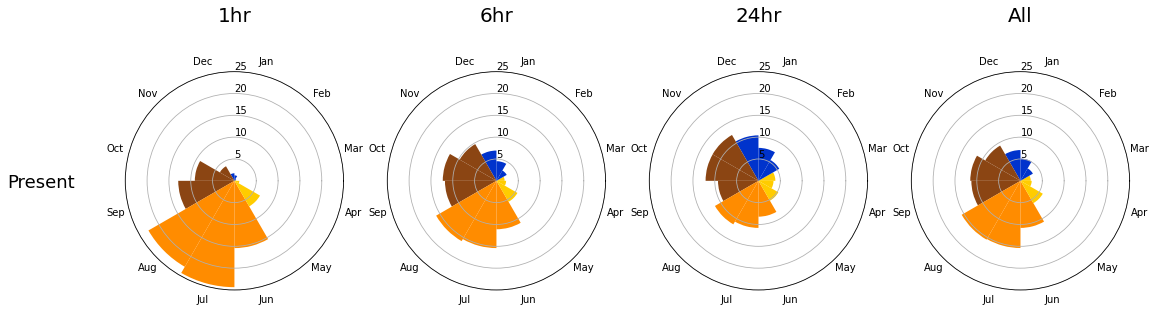

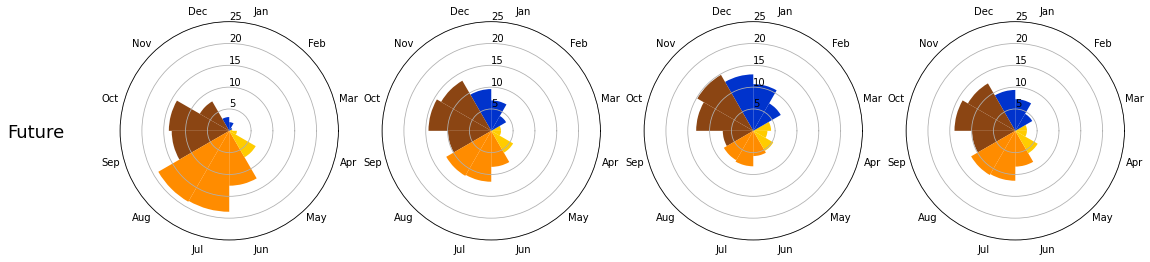

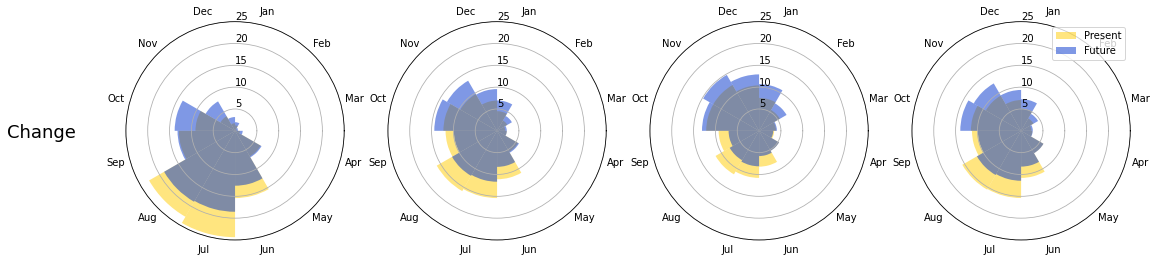

In [42]:
# List of durations and corresponding subplot titles
durations = ['1',  '6', "24"] # ['0.5', '1', '2', '3', '6',"12", '24']
titles = [f"{i}hr" for i in durations]

##########################################################
## present
##########################################################
fig, axes = plt.subplots(1, 4, figsize=(18, 10), subplot_kw={'polar': True})
fig.subplots_adjust(hspace=0.5)

# Loop through durations, axes, and titles
for ax, duration, title in zip(axes, durations, titles):
    this_duration = present[present['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    plot_polar_months_plot(this_duration, ax, True, title, 25, name_variable_to_plot='Percentage')
plot_polar_months_plot(present, axes[3], True, "All",25, name_variable_to_plot = 'Percentage')    
fig.text(0.06, 0.50, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');

##########################################################
## Future
##########################################################
fig, axes = plt.subplots(1, 4, figsize=(18, 10), subplot_kw={'polar': True})
fig.subplots_adjust(hspace=0.5)

for ax, duration, title in zip(axes, durations, titles):
    this_duration = future[future['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    plot_polar_months_plot(this_duration, ax, False, title, 25, name_variable_to_plot='Percentage')
plot_polar_months_plot(future, axes[3], False, "Present (all)",25, name_variable_to_plot = 'Percentage')    
fig.text(0.06, 0.50, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');


# ##########################################################
# ## Present and future overlaid
# ##########################################################
fig, axes = plt.subplots(1, 4, figsize=(18, 10), subplot_kw={'polar': True})
fig.subplots_adjust(hspace=0.5)

for ax, duration, title in zip(axes, durations, titles):
    this_duration_pres = present[present['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    this_duration_future = future[future['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    plot_polar_months_plot_overlay(this_duration_pres, this_duration_future, ax, False, 'All', False, 25) 
plot_polar_months_plot_overlay(present, future, axes[3], False, 'All', True, 25) 
fig.text(0.06, 0.50, 'Change', va='center', ha='center', fontsize=18, rotation='horizontal');

## Comparing plotting count of events vs percentage of events

In [ ]:
# fig = plt.figure(figsize=(18, 10))
# fig.subplots_adjust(hspace=0.5)
# ax1 = plt.subplot(231, polar=True)
# ax2 = plt.subplot(232, polar=True)
# plot_polar_months_plot(events_props_dict_present, ax1, "UKCP18 Present", 30, name_variable_to_plot = 'Count')
# plot_polar_months_plot(events_props_dict_future, ax2,"UKCP18 Future", 30, name_variable_to_plot = 'Count')

# ax3 = plt.subplot(234, polar=True)
# ax4 = plt.subplot(235, polar=True)
# ax5 = plt.subplot(236, polar=True)
# plot_polar_months_plot(events_props_dict_present, ax3, "UKCP18 Present (% of events)", 18, name_variable_to_plot = 'Percentage')
# plot_polar_months_plot(events_props_dict_future, ax4,"UKCP18 Future (% of events)", 18, name_variable_to_plot = 'Percentage')
# plot_polar_months_plot_overlay(events_props_dict_present, events_props_dict_future, ax5, "Present vs Future (% of events)", 30)

## All events, divided geographically

Shows that:
- For the NE, NW, ME regions events are more concentrated in the summer months
- SE, SW have more events in Autumn
- These patterns are emphasised in the future?

In [41]:
# # Create subplots with 2 rows and 5 columns for present and future
# fig, axes = plt.subplots(3, 5, figsize=(18, 15), subplot_kw={'polar': True})
# fig.subplots_adjust(hspace=-0.3)

# # Loop through the areas for both present and future
# for i, area in enumerate(areas):
#     # Filter for present data
#     present_events = present[present['area'] == area]
    
#     # Filter for future data
#     future_events = future[future['area'] == area]
    
#     # Plot for present data (1st row)
#     plot_polar_months_plot(present_events, axes[0, i], True, area, 25, name_variable_to_plot='Percentage')
    
#     # Plot for future data (2nd row)
#     plot_polar_months_plot(future_events, axes[1, i], True, None, 25, name_variable_to_plot='Percentage')
#     plot_polar_months_plot_overlay(present_events, future_events, axes[2, i], False, "Present vs Future (% of events)", True, 22)
    
# # Add row labels for "Present" and "Future"
# fig.text(0.06, 0.75, 'Present', va='center', ha='center', fontsize=16, rotation='horizontal')
# fig.text(0.06, 0.50, 'Future', va='center', ha='center', fontsize=16, rotation='horizontal');          

### Plot for each area, divided by durations, for the present

In [39]:
# def plot_by_dur_and_area(area_str):
#     fig, axes = plt.subplots(1,4, figsize=(12, 6), subplot_kw={'polar': True})
#     fig.subplots_adjust(hspace=0.5)
#     for ax, duration, title in zip(axes, durations, titles):
#         this_duration_pres = present[present['DurationRange_simple'] == duration]
#         this_duration_area = this_duration_pres[this_duration_pres['area'] ==area_str]
#         this_area = present[present['area'] ==area_str]
#         plot_polar_months_plot(this_duration_area, ax, True, duration, rmax, name_variable_to_plot='Percentage')
#     plot_polar_months_plot(this_area, axes[3], True, 'All', rmax, name_variable_to_plot='Percentage')    
#     fig.text(0.02, 0.5, area_str, va='center', ha='center', fontsize=16, rotation='horizontal');

# # List of durations and corresponding subplot titles
# durations = ['<4hr', '4-12hr', '12hr+']
# titles = ["<4hr",  "4-12hr", "12hr+"]
# rmax =35    
    
# plot_by_dur_and_area('NW')
# plot_by_dur_and_area('NE')
# plot_by_dur_and_area('ME')
# plot_by_dur_and_area('SE')
# plot_by_dur_and_area('SW')

In [40]:
# def plot_by_dur_and_area_overlaid(area_str):
   
#     fig, axes = plt.subplots(1,4, figsize=(12, 6), subplot_kw={'polar': True})
#     fig.subplots_adjust(hspace=0.5)
#     for ax, duration, title in zip(axes, durations, titles):
#         this_duration_pres = present[present['DurationRange_simple'] == duration]
#         this_duration_pres_area = this_duration_pres[this_duration_pres['area'] ==area_str]
        
#         this_duration_future = future[future['DurationRange_simple'] == duration]
#         this_duration_future_area = this_duration_future[this_duration_future['area'] ==area_str]
        
#         ## This area, for all durations
#         this_area_pres = present[present['area'] ==area_str]
#         this_area_future = future[future['area'] ==area_str]
        
#         plot_polar_months_plot_overlay(this_duration_pres_area, this_duration_future_area, ax, True, duration, False, rmax)
#     plot_polar_months_plot_overlay(this_area_pres, this_area_future, axes[3], True, duration, False, rmax)
#     fig.text(0.02, 0.5, area_str, va='center', ha='center', fontsize=16, rotation='horizontal');

    
# # List of durations and corresponding subplot titles
# durations = ['<4hr', '4-12hr', '12hr+']
# titles = ["<4hr",  "4-12hr", "12hr+"]
# rmax =35    
    
# plot_by_dur_and_area_overlaid('NW')
# plot_by_dur_and_area_overlaid('NE')
# plot_by_dur_and_area_overlaid('ME')
# plot_by_dur_and_area_overlaid('SE')
# plot_by_dur_and_area_overlaid('SW')

## Theta and R2 values 

## Present + future + change (all durations lumped)  

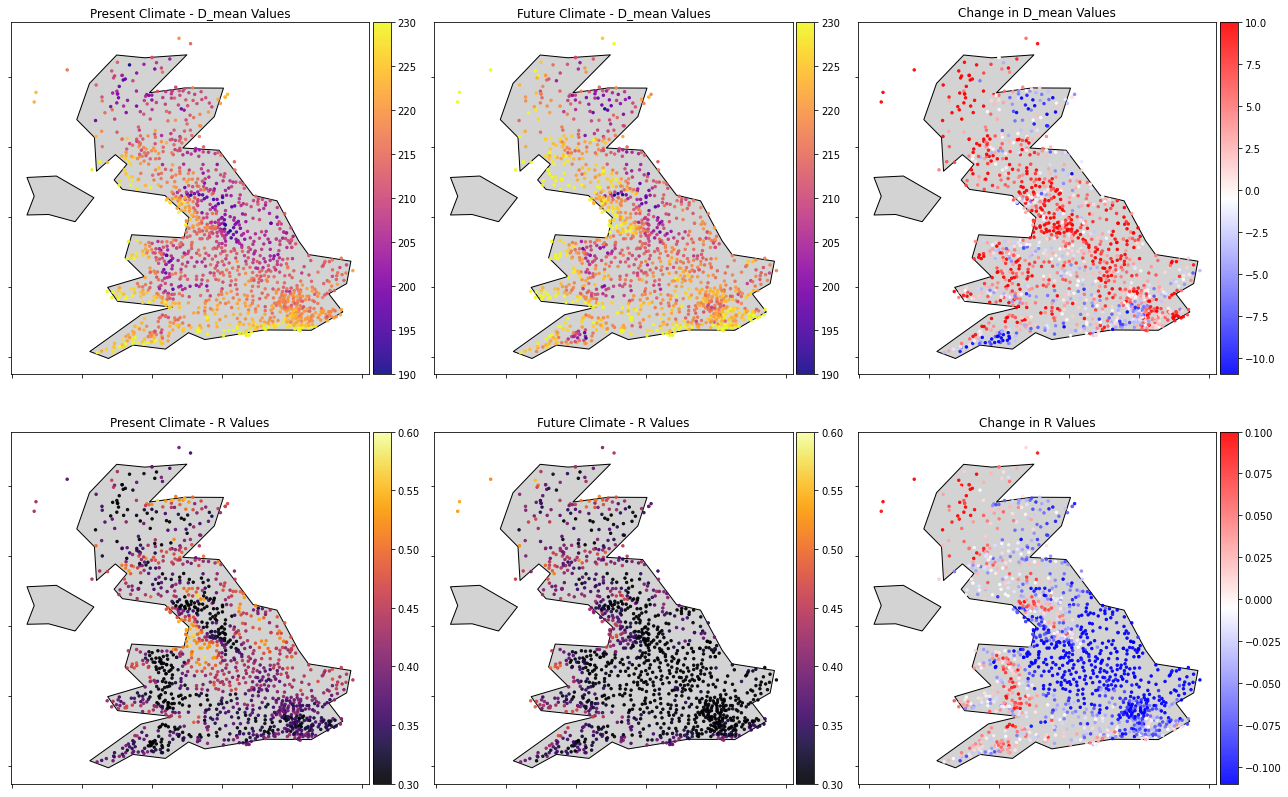

In [146]:
# Create a figure and axes for the six subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
variable1 = 'D_mean'
variable2 = 'R'
plot_present_future_changes(axes, 0, df_changes_all, variable1, f'{variable1}_present', f'{variable1}_future',
                           f'{variable1}_diff', 'plasma', 'bwr', 190,230, -10, +10)
plot_present_future_changes(axes, 1, df_changes_all, variable2, f'{variable2}_present', f'{variable2}_future',
                            f'{variable2}_diff', 'inferno', 'bwr', 0.3,0.6, -0.1, 0.1)

### Day of year - present, future, change

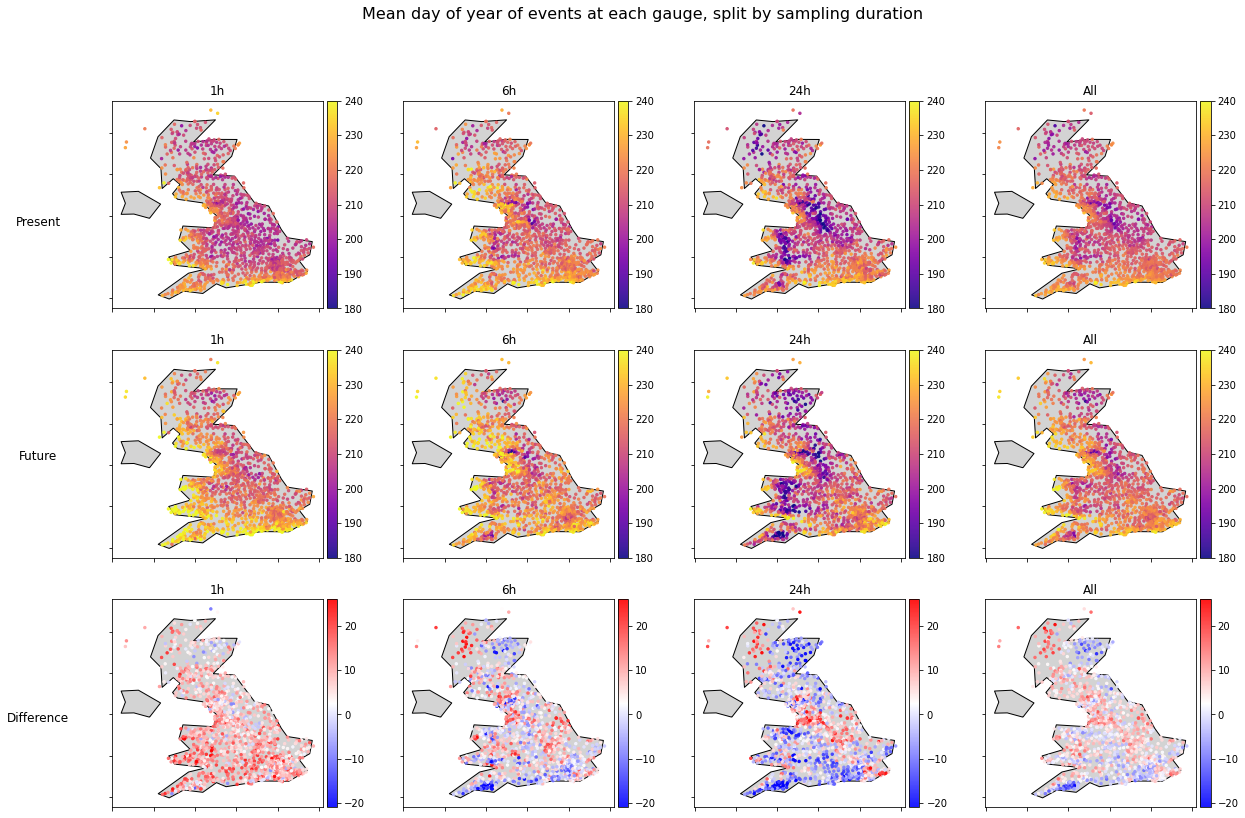

In [149]:
fig, axes = plt.subplots(3, 4, figsize=(20, 13))

cmap = 'plasma'

#################################################
# Present
#################################################
variable = "D_mean"
variable_to_plot = f'{variable}_present'
low_lim=180
high_lim=240

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(1)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[0,0], this_duration, '1h', tbo_vals,
                   variable_to_plot, low_lim, high_lim, cmap)

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(6)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[0,1], this_duration, '6h', tbo_vals, 
                   variable_to_plot, low_lim, high_lim, cmap)

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(24)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[0,2], this_duration, '24h', tbo_vals, 
                   variable_to_plot, low_lim, high_lim, cmap=cmap)    


### Plot 'All' values
present_data = df_changes_all[['gauge_num', variable_to_plot]].copy()
present_data['Climate'] = 'present'  # Add a Climate column for clarity   

plot_values_on_map(axes[0,3], present_data, 'All', tbo_vals, 
                   variable_to_plot, vmin=low_lim, vmax=high_lim, cmap=cmap)


#################################################
# Future
#################################################   
variable = "D_mean"
variable_to_plot = f'{variable}_future'
low_lim=180
high_lim=240

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(1)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[1,0], this_duration, '1h', tbo_vals,
                   variable_to_plot, low_lim, high_lim, cmap)

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(6)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[1,1], this_duration, '6h', tbo_vals, 
                   variable_to_plot, low_lim, high_lim, cmap)

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(24)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[1,2], this_duration, '24h', tbo_vals, 
                   variable_to_plot, low_lim, high_lim, cmap=cmap)    


### Plot 'All' values
future_data = df_changes_all[['gauge_num', variable_to_plot]].copy()
future_data['Climate'] = 'future'  # Add a Climate column for clarity   

plot_values_on_map(axes[1,3], future_data, 'All', tbo_vals, 
                   variable_to_plot, vmin=low_lim, vmax=high_lim, cmap=cmap)



#################################################
# Difference
#################################################
variable = 'D_mean'
variable_to_plot = f'{variable}_diff'
low_lim=-21
high_lim=+26
cmap = 'RdYlGn'

present_data = df_changes_all[['gauge_num', variable_to_plot]].copy()
present_data['Climate'] = 'present'  # Add a Climate column for clarity    

# For each duration
this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(1)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[2,0], this_duration, '1h', tbo_vals,
                   variable_to_plot, low_lim, high_lim, 'bwr')

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(6)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[2,1], this_duration, '6h', tbo_vals, 
                   variable_to_plot, low_lim, high_lim, 'bwr')

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(24)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[2,2], this_duration, '24h', tbo_vals, 
                   variable_to_plot, low_lim, high_lim, cmap='bwr')    

# All
plot_values_on_map(axes[2,3], present_data, 'All', tbo_vals, 
                   variable_to_plot, vmin=low_lim, vmax=high_lim, cmap='bwr')

fig.text(0.08, 0.750, 'Present', va='center', ha='center', fontsize=12, rotation='horizontal');
fig.text(0.08, 0.5, 'Future', va='center', ha='center', fontsize=12, rotation='horizontal');
fig.text(0.08, 0.22, 'Difference', va='center', ha='center', fontsize=12, rotation='horizontal');

plt.suptitle('Mean day of year of events at each gauge, split by sampling duration', fontsize=16);

###  R (how dispersed events are)

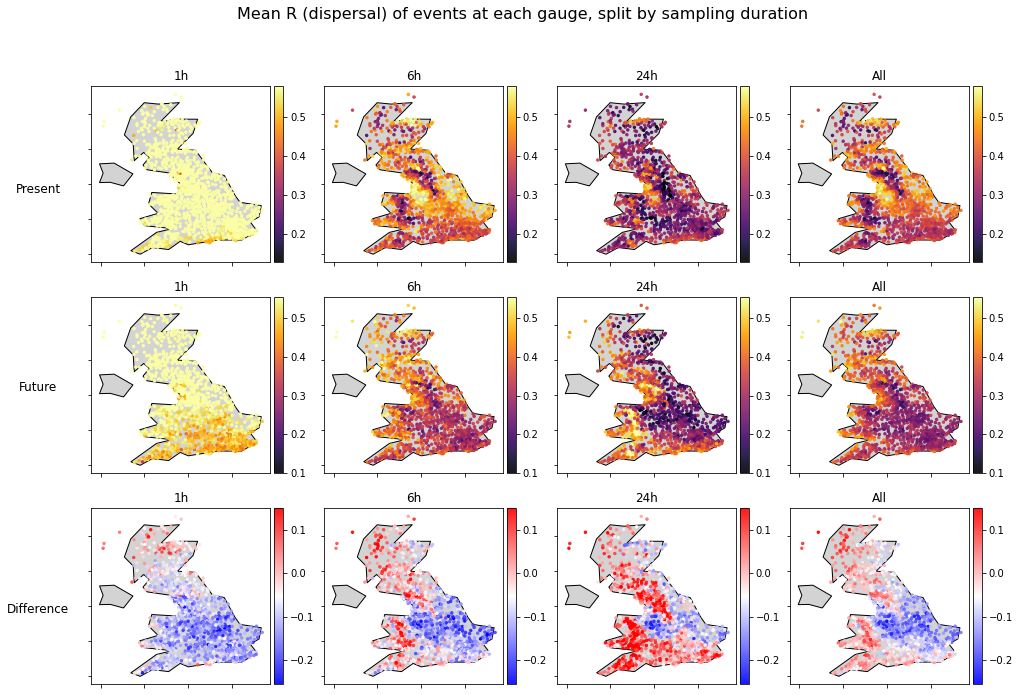

In [141]:
fig, axes = plt.subplots(3, 4, figsize=(16, 11))
cmap = 'inferno'

#################################################
# Present
#################################################
variable = "R"
variable_to_plot = f'{variable}_present'

# Get all data
present_data = df_changes_all[['gauge_num', variable_to_plot]].copy()
present_data['Climate'] = 'present'  # Add a Climate column for clarity   

low_lim=present_data['R_present'].min()
high_lim=present_data['R_present'].max()

# Plot for each duration
this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(1)][['gauge_num', variable_to_plot]]
# low_lim=this_duration['R_present'].min()
# high_lim=this_duration['R_present'].max()
plot_values_on_map(axes[0,0], this_duration, '1h', tbo_vals,
                   variable_to_plot, low_lim, high_lim, cmap)

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(6)][['gauge_num', variable_to_plot]]
# low_lim=this_duration['R_present'].min()
# high_lim=this_duration['R_present'].max()
plot_values_on_map(axes[0,1], this_duration, '6h', tbo_vals, 
                   variable_to_plot, low_lim, high_lim, cmap)

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(24)][['gauge_num', variable_to_plot]]
# low_lim=this_duration['R_present'].min()
# high_lim=this_duration['R_present'].max()
plot_values_on_map(axes[0,2], this_duration, '24h', tbo_vals, 
                   variable_to_plot, low_lim, high_lim, cmap=cmap)  

### Plot 'All' values
plot_values_on_map(axes[0,3], present_data, 'All', tbo_vals, 
                   variable_to_plot, vmin=low_lim, vmax=high_lim, cmap=cmap)

#################################################
# Future
#################################################   
variable = "R"
variable_to_plot = f'{variable}_future'

future_data = df_changes_all[['gauge_num', variable_to_plot]].copy()
future_data['Climate'] = 'future'  # Add a Climate column for clarity   

low_lim=future_data['R_future'].min()
high_lim=future_data['R_future'].max()

# Plot for each duration
this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(1)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[1,0], this_duration, '1h', tbo_vals,
                   variable_to_plot, low_lim, high_lim, cmap)

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(6)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[1,1], this_duration, '6h', tbo_vals, 
                   variable_to_plot, low_lim, high_lim, cmap)

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(24)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[1,2], this_duration, '24h', tbo_vals, 
                   variable_to_plot, low_lim, high_lim, cmap=cmap)    


### Plot 'All' values
plot_values_on_map(axes[1,3], future_data, 'All', tbo_vals, 
                   variable_to_plot, vmin=low_lim, vmax=high_lim, cmap=cmap)


#################################################
# Difference
#################################################
variable = 'R'
variable_to_plot = f'{variable}_diff'

## All
diff_data = df_changes_all[['gauge_num', variable_to_plot]].copy()
diff_data['Climate'] = 'present'  # Add a Climate column for clarity    

low_lim=diff_data['R_diff'].min()
high_lim=diff_data['R_diff'].max()
cmap = 'bwr'

## By duration
this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(1)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[2,0], this_duration, '1h', tbo_vals,
                   variable_to_plot, low_lim, high_lim, 'bwr')

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(6)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[2,1], this_duration, '6h', tbo_vals, 
                   variable_to_plot, low_lim, high_lim, 'bwr')

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(24)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[2,2], this_duration, '24h', tbo_vals, 
                   variable_to_plot, low_lim, high_lim, cmap='bwr')    

# Plot all
plot_values_on_map(axes[2,3], diff_data, 'All', tbo_vals, 
                   variable_to_plot, vmin=low_lim, vmax=high_lim, cmap='bwr')

fig.text(0.08, 0.750, 'Present', va='center', ha='center', fontsize=12, rotation='horizontal');
fig.text(0.08, 0.5, 'Future', va='center', ha='center', fontsize=12, rotation='horizontal');
fig.text(0.08, 0.22, 'Difference', va='center', ha='center', fontsize=12, rotation='horizontal');

plt.suptitle('Mean R (dispersal) of events at each gauge, split by sampling duration', fontsize=16);